In [61]:
import random
import time
import datetime

import numpy as np
import pandas as pd

import torch
from transformers import BertModel, BertTokenizer

from sklearn.decomposition import PCA
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sn

# 1. Implementation

### Get sentences

In [62]:
def get_sentences(word_of_interest, min_words, max_words):
    """
    """
    # Cleaned data files.
    directory = '/raid/antoloui/Master-thesis/Data/Cleaned/'
    files = ['train.raw', 'dev.raw', 'test.raw']
    paths = [directory+f for f in files]
    
    # Get sentences with word of interest in it.
    sentences = []
    for filepath in paths:
        with open(filepath) as myfile:
            for i, line in enumerate(myfile):
                words = line.split()
                if len(words) > min_words and len(words) < max_words and word_of_interest in words:
                    sentences.append(line)
    return sentences

### Encode words

In [63]:
def encode_words(model_name_or_path, sentences):
    """
    Given a list of sentences and a model, get the embeddings of each word in the sentences.
    """
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='../_cache') # Will output all hidden_states.

    print("   Tokenizing sentences...")
    marked_text = ["[CLS] " + sent + " [SEP]" for sent in sentences]
    tokenized_text = [tokenizer.tokenize(sent) for sent in marked_text]
    indexed_tokens = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_text]
    #indexed_tokens = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]
    
    lengths = [len(i) for i in indexed_tokens]
    max_len = max(lengths) if max(lengths) <= 512 else 512

    print("   Padding/Truncating sentences to {} tokens...".format(max_len))
    padded = pad_sequences(indexed_tokens, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # Concatenate the tensors for all layers. We use `stack` here to create a new dimension in the tensor.
    hidden_states = torch.stack(output[2], dim=0)

    # Switch around the “layers” and “tokens” dimensions with permute.
    hidden_states = hidden_states.permute(1,2,0,3)
    
    # For each sentence, um the last four layers of each token as their embbeding.
    sentence_vecs = []
    for sent in hidden_states:
        token_vecs = []
        for token in sent:
            sum_vec = torch.sum(token[-4:], dim=0)
            token_vecs.append(np.array(sum_vec))
        sentence_vecs.append(token_vecs)
    sentence_vecs = np.array(sentence_vecs)
        
    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(sentence_vecs.shape[2])]
    df = pd.DataFrame(columns=cols)
    df['Token'] = None
    df['Sentence'] = None
    
    for i, sent in enumerate(sentences):
        tmp_df = pd.DataFrame(data=sentence_vecs[i,:,:], columns=cols)
        tmp_df['Token'] = list(np.append(tokenized_text[i], ['[PAD]']*(max_len-len(tokenized_text[i]))))
        tmp_df['Sentence'] = [sent]*max_len
        df = pd.concat([df, tmp_df], axis=0)
    
    df = df.loc[~df['Token'].isin(['[CLS]', '[SEP]', '[PAD]'])]
    df.reset_index(drop=True, inplace=True)
    return df



def get_embeddings(df, sentences, word_of_interest, model_name_or_path):
    """
    Given the dataframe, get the embeddings of each word.
    """
    embeddings = []
    # In each sentence, get the embedding of the word of interest.
    for i, sent in enumerate(sentences):
        
        # If word_i is entirely present (not segmented), take its embedding.
        if word_of_interest in df.loc[df["Sentence"]==sent, "Token"].values.tolist():
            word_embedding = df.loc[(df['Sentence']==sent) & (df['Token']==word_of_interest), ~df.columns.isin(['Token','Sentence'])].values[0]
            embeddings.append(word_embedding)

        # If word is segmented, find the n-grams and average their embeddings.
        else:
            tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
            grams = tokenizer.tokenize(word_of_interest)
            avg_df = df.loc[(df['Sentence']==sent) & (df['Token'].isin(grams)), ~df.columns.isin(['Token','Sentence'])]
            avg = avg_df.mean(axis=0).values
            embeddings.append(avg)
       
    return np.array(embeddings)

### PCA to 50D

In [64]:
def perform_pca(word_embeddings):
    """
    """
    # PCA
    pca = PCA(n_components=50, random_state = 42)
    pca_result = pca.fit_transform(word_embeddings)
    print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

    # Create pandas dataframe.
    cols = ['pca-'+str(i+1) for i in range(pca_result.shape[1])]
    pca_df = pd.DataFrame(data=pca_result[:,:], columns=cols)
    
    # Create boxplots.
    boxplot = pca_df.boxplot(column=pca_df.columns.tolist(), grid=False, rot=90, fontsize=15, figsize=(30,10))
    return boxplot

### Run all

In [65]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



def run(word_of_interest, min_words=0, max_words=25, nb_samples=2500):
    """
    """
    #----------------------------------------
    # Get all sentences with word of interest
    #----------------------------------------
    print("Retrieving sentences with word: '{}'...".format(word_of_interest))
    t0 = time.time()
    sentences = get_sentences(word_of_interest, min_words, max_words)
    print("   Number of sentences retrieved: {}   -   Took: {:}".format(len(sentences), format_time(time.time() - t0)))
    print("   Taking a sample of {} sentences...\n".format(nb_samples))
    sample_sentences = random.sample(sentences, nb_samples)
    
    
    #---------------------
    # Get word embeddings
    #---------------------
    print("Encoding sentences with BERT-base...")
    t0 = time.time()
    bert_df = encode_words('bert-base-cased', sample_sentences)
    bert_embeddings = get_embeddings(bert_df, sample_sentences, word_of_interest, 'bert-base-cased')
    elapsed = time.time() - t0
    print("   Encoding took: {:}  ({:.2f} s/sentences)\n".format(format_time(elapsed), elapsed/len(sample_sentences)))

    print("Encoding sentences with NetBERT...")
    t0 = time.time()
    netbert_df = encode_words('../_models/netbert/checkpoint-1027000/', sample_sentences)
    netbert_embeddings = get_embeddings(netbert_df, sample_sentences, word_of_interest, '../_models/netbert/checkpoint-1027000/')
    elapsed = time.time() - t0
    print("   Encoding took: {:}  ({:.2f} s/sentences)\n".format(format_time(elapsed), elapsed/len(sample_sentences)))
    
    
    #---------------------
    # Perform PCA-50
    #---------------------
    print("Performing PCA-50 on BERT-base embeddings...")
    bert_boxplots = perform_pca(bert_embeddings)

    print("Performing PCA-50 on NetBERT embeddings...")
    netbert_boxplots = perform_pca(netbert_embeddings)
    
    return

# 2. Test

### "switch"

Retrieving sentences with word: 'switch'...
   Number of sentences retrieved: 1786212   -   Took: 0:05:00
   Taking a sample of 2500 sentences...

Encoding sentences with BERT-base...
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 85 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
   Encoding took: 0:06:13  (0.15 s/sentences)

Encoding sentences with NetBERT...
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 85 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
   Encoding took: 0:06:09  (0.15 s/sentences)

Performing PCA-50 on BERT-base embeddings...
Cumulative explained variation for 50 principal components: 0.7212211489677429
Performing PCA-50 on NetBERT embeddings...
Cumulative explained variation for 50 principal components: 0.6776748895645142


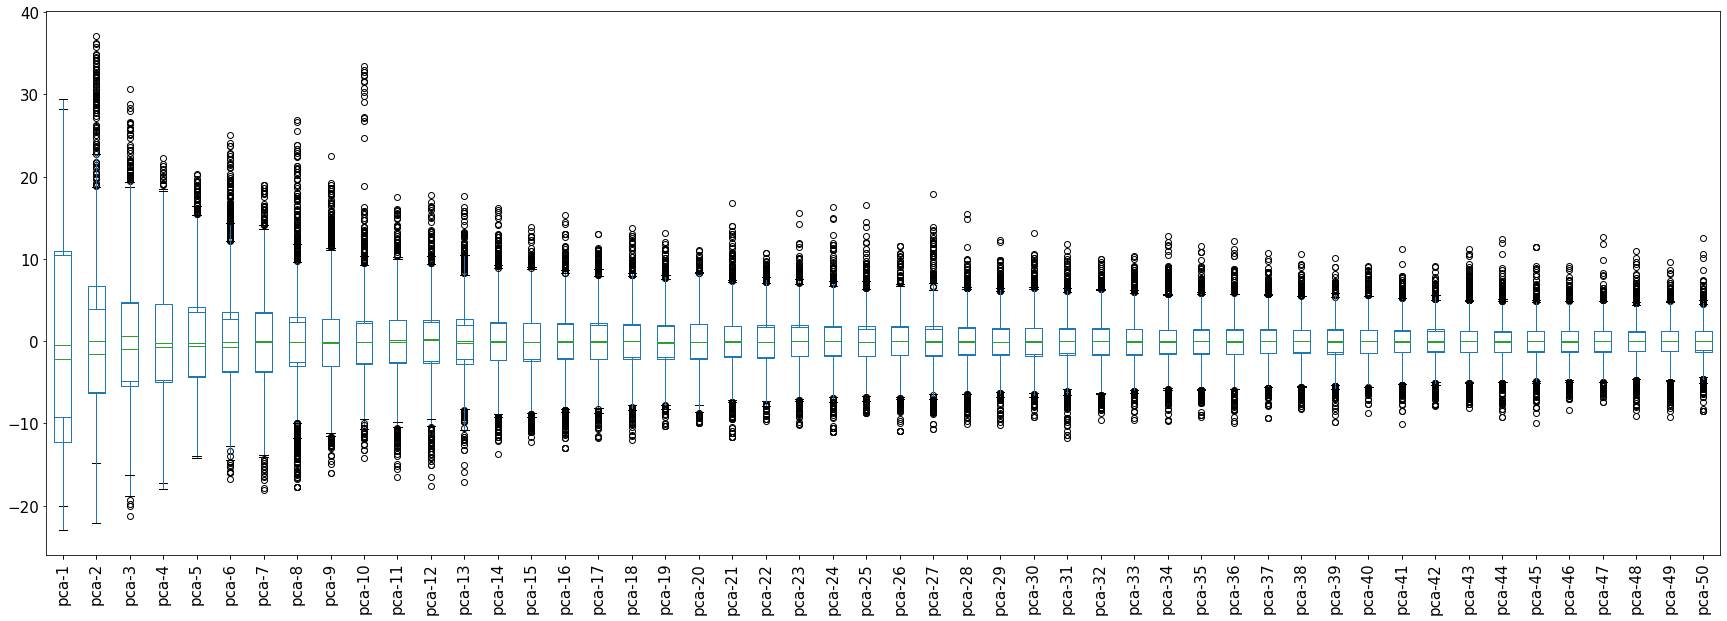

In [66]:
word_of_interest = 'switch'
run(word_of_interest)

### "router"

Retrieving sentences with word: 'router'...
   Number of sentences retrieved: 1208690   -   Took: 0:05:34
   Taking a sample of 2500 sentences...

Encoding sentences with BERT-base...
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 143 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
   Encoding took: 0:34:04  (0.82 s/sentences)

Encoding sentences with NetBERT...
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 143 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
   Encoding took: 0:11:28  (0.28 s/sentences)

Performing PCA-50 on BERT-base embeddings...
Cumulative explained variation for 50 principal components: 0.7649551630020142
Performing PCA-50 on NetBERT embeddings...
Cumulative explained variation for 50 principal components: 0.7298299074172974


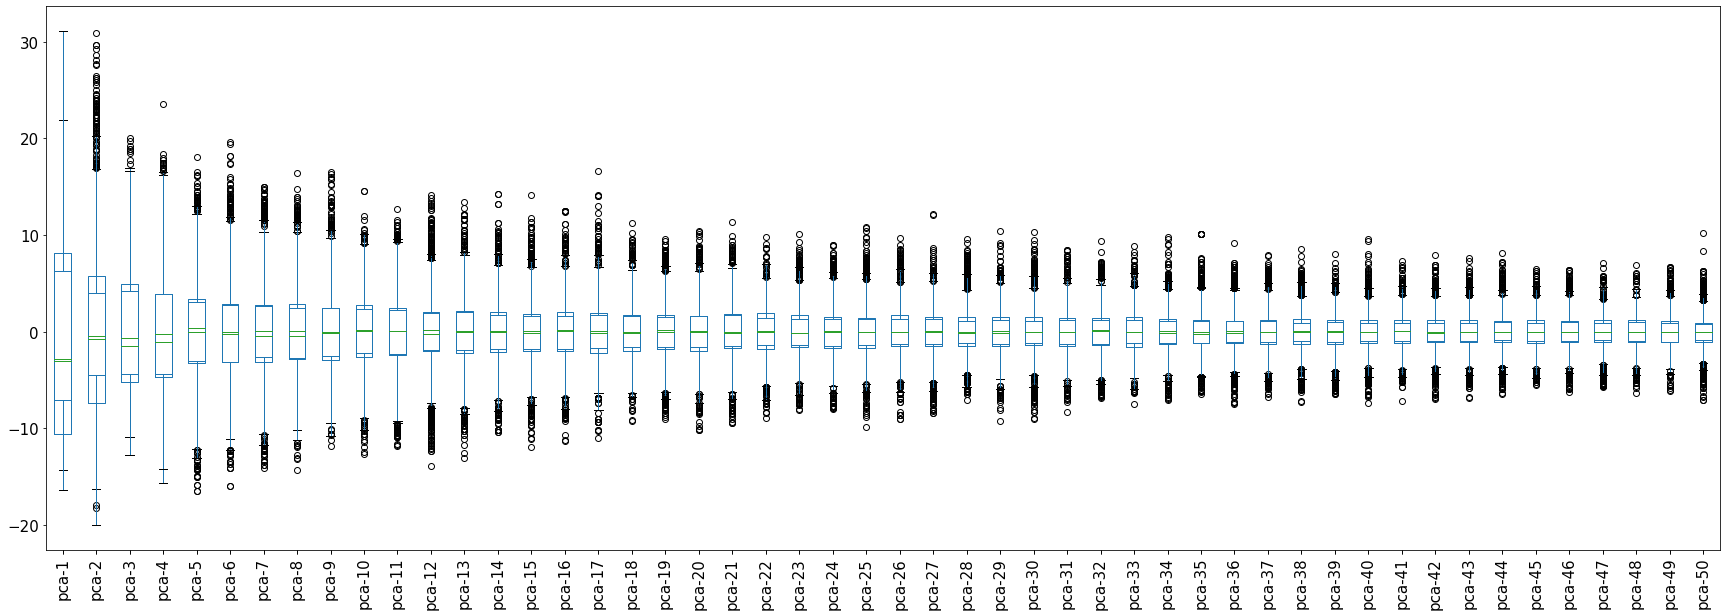

In [67]:
word_of_interest = 'router'
run(word_of_interest)

Performing PCA-50 on BERT-base embeddings...
Cumulative explained variation for 50 principal components: 0.7208901047706604
  PCA took: 0:00:01



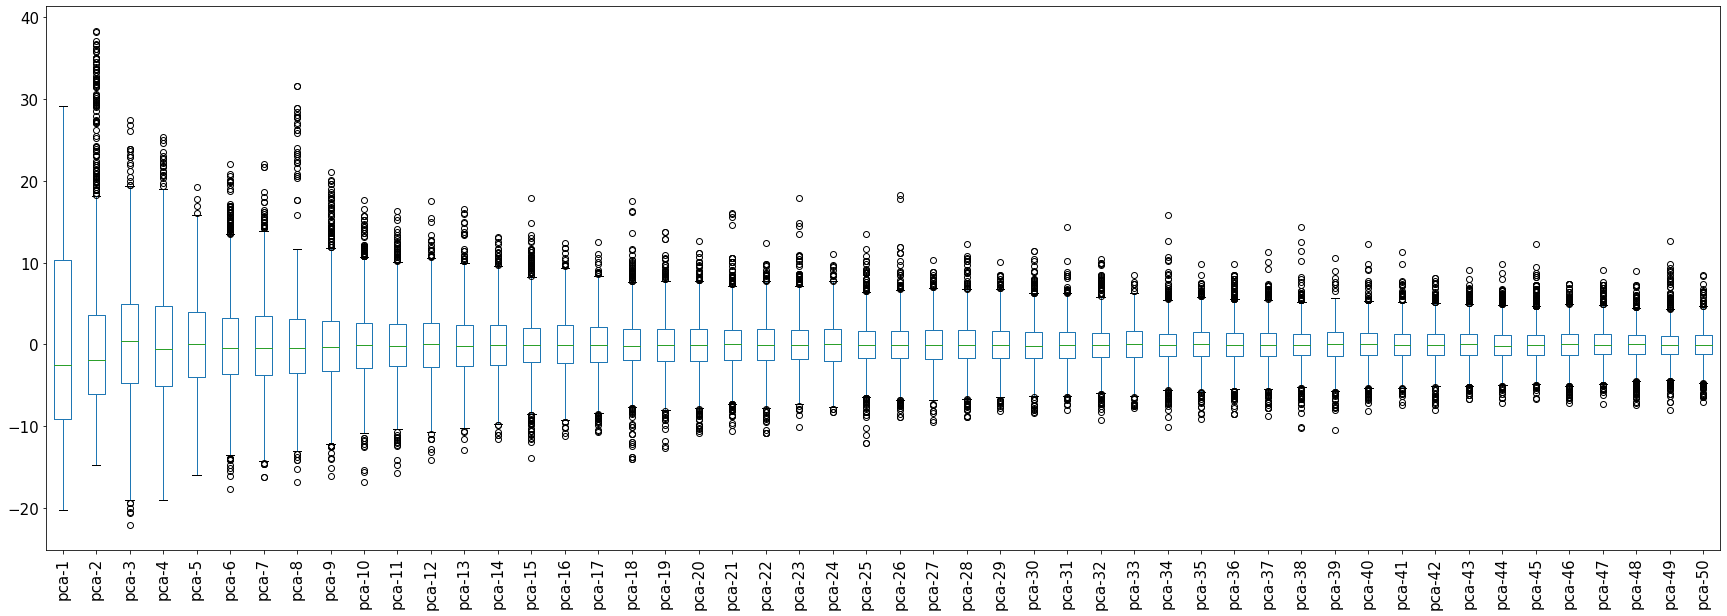